In [6]:
import torch
import torch.nn as nn
from loss import fff_loss
import tqdm
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
import numpy as np
import copy
import matplotlib.pyplot as plt

import distributions as d
import evaluation as e
import models as m

import optuna
from optuna.trial import TrialState

c:\Users\Fritz\anaconda3\envs\analyzing_invs\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_hidden_layers=1):
        super(MLP, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = []
        self.n_hidden_layers = n_hidden_layers
        for _ in range(self.n_hidden_layers): 
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.input_layer(x))
        for i in range(self.n_hidden_layers):
            x = self.relu(self.hidden_layers[i](x))
        x = self.output_layer(x)
        return x

class FreeFormFlow(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_blocks=1):
        super().__init__()
        #self.encoder = MLP(input_dim, hidden_dim, output_dim, n_hidden_layers=n_hidden_layers)
        #self.decoder = MLP(output_dim, hidden_dim, input_dim, n_hidden_layers=n_hidden_layers)
        self.encoder = m.resnet(input_dim=2, hidden_dim=128, n_blocks=1, output_dim=2)
        self.decoder = m.resnet(input_dim=2, hidden_dim=128, n_blocks=1, output_dim=2)
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
    def sample(self, num_samples):
        z = torch.normal(mean=torch.zeros((num_samples, self.input_dim)), std=torch.ones((num_samples, self.input_dim)))
        return self.decoder(z)
    
    def logprob(self, x):
        print("Warning: FFF logprob not implemented!")
        return torch.zeros_like(x)

# Training function for FFF

In [34]:
def train_fff(model, batchsize=1000, epochs=500, lr=0.0002, track_kl=True,
              calculate_mmd=False, beta=1., plot=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    metrics = {}
    loss_history = []
    mmd_history = []    
    mmd_epochs = []
    kl_history = []
    kl_epochs = []
    model_screenshots = []
    
    for epoch in tqdm.tqdm(range(epochs)):
        optimizer.zero_grad()
        model.train()
        
        x, _ = make_moons(n_samples=batchsize, shuffle=True, noise=0.1)        
        scaler = StandardScaler()
        x_normalized = scaler.fit_transform(x)
        x = torch.tensor(x_normalized, dtype=torch.float32)
        
        loss = fff_loss(x, encode=model.encoder, decode=model.decoder, beta=beta)
        
        loss.mean().backward()
        loss_history.append(loss.mean().item())
        
        optimizer.step()
        
        
        if epoch%20 == 0:
            model.eval()
            if calculate_mmd:
                mmd_history.append(e.mmd_inverse_multi_quadratic(x, model.sample(batchsize)).item())
                mmd_epochs.append(epoch)   
            if track_kl:   
                moons_dist = d.moons_distribution()
                target = torch.Tensor(moons_dist.score_samples(x))
                kl_history.append(e.generalized_kl(model.logprob(x), target).mean().item())
                kl_epochs.append(epoch)
            model_screenshots.append(copy.deepcopy(model))
    metrics["fff_loss"] = loss_history
    if calculate_mmd: metrics["mmd"] = (mmd_epochs, mmd_history)
    if track_kl: metrics["kl"] = (kl_epochs, kl_history)
    if plot:
        fig, axs = plt.subplots(figsize=(5, 4))

        axs.plot(metrics["fff_loss"], label="FFF loss")
        axs.legend()
        ax2 = axs.twinx()
        ax2.plot(metrics["mmd"][0], metrics["mmd"][1], label="MMD", color="orange")
        ax2.legend(loc=2)
        ax2.set_yscale("log")
        plt.show()
    return model, metrics, model_screenshots

100%|██████████| 5000/5000 [06:33<00:00, 12.70it/s]


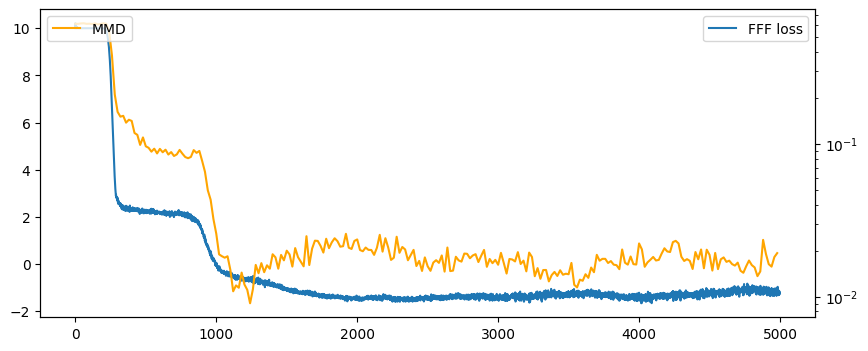

In [44]:
fff = FreeFormFlow(input_dim=2,
                   hidden_dim=176,
                   output_dim=2,
                   n_hidden_layers=9)

fff, metrics, _ = train_fff(fff, epochs=5000, lr=0.03, batchsize=600,
                            track_kl=False, calculate_mmd=True, beta=5.)

# hidden_dim: 176
#     n_layers: 9
#     lr: 0.030123691902736238
#     batchsize: 631
#     beta: 5.060924805069871

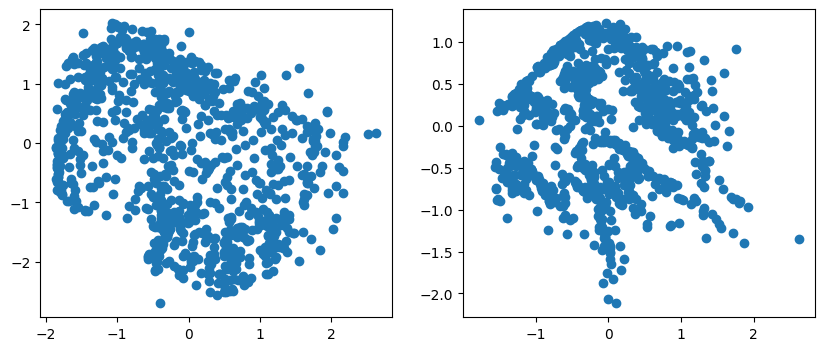

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs = axs.flatten()

samples = fff.sample(1000).detach().numpy()
axs[0].scatter(samples[:,0], samples[:,1])

x, _ = make_moons(n_samples=1000, shuffle=True, noise=0.1)        
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)
x = torch.tensor(x_normalized, dtype=torch.float32)
z = fff.encoder(x).detach().numpy()
axs[1].scatter(z[:,0], z[:,1])

# Optuna

In [41]:
regressor_hidden = 150
regressor_layers = 3
regressor_lr = 0.001
regressor_batchsize = 500
regressor_epochs = 2000

def define_fff(trial):
  hidden_dim = trial.suggest_int("hidden_dim", 4, 300)
  n_hidden_layers = trial.suggest_int("n_layers", 1, 10)
  return FreeFormFlow(2, 
                      hidden_dim, 
                      2, 
                      n_hidden_layers=1)

def fff_objective(trial):
  model = define_fff(trial)

  lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
  batchsize = trial.suggest_int("batchsize", 1, 700)
  beta = trial.suggest_float("beta", 1e-5, 1e2, log=True)

  _, metrics, _ = train_fff(model, 
                         batchsize=batchsize, 
                         epochs=3000, 
                         lr=lr, 
                         track_kl=False,
                         calculate_mmd=True, 
                         beta=beta, 
                         plot=False) 
  
  loss = np.mean(metrics["mmd"][-20:])
  return loss

def run_regressor_study(study, objective, n_trials=30):
  study.optimize(objective, n_trials=n_trials, timeout=None)

  pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
  complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

  print("Study statistics: ")
  print("  Number of finished trials: ", len(study.trials))
  print("  Number of pruned trials: ", len(pruned_trials))
  print("  Number of complete trials: ", len(complete_trials))

  print("Best trial:")
  trial = study.best_trial

  print("  Value: ", trial.value)

  print("  Params: ")
  for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
    
  fig = optuna.visualization.plot_param_importances(study)
  fig.show()

In [42]:
fff_study = optuna.create_study(direction="minimize")
run_regressor_study(fff_study, fff_objective)

[I 2024-08-05 19:40:02,105] A new study created in memory with name: no-name-3c18e9fb-b52e-4a0e-993d-621bb3c198b7
100%|██████████| 3000/3000 [00:22<00:00, 130.67it/s]
[I 2024-08-05 19:40:25,070] Trial 0 finished with value: 745.045921138823 and parameters: {'hidden_dim': 16, 'n_layers': 3, 'lr': 0.001135858093144839, 'batchsize': 396, 'beta': 6.449760846191675e-05}. Best is trial 0 with value: 745.045921138823.
100%|██████████| 3000/3000 [01:43<00:00, 28.85it/s]
[I 2024-08-05 19:42:09,063] Trial 1 finished with value: 745.1520583850146 and parameters: {'hidden_dim': 265, 'n_layers': 2, 'lr': 1.1753886569053401e-05, 'batchsize': 673, 'beta': 21.569730246583852}. Best is trial 0 with value: 745.045921138823.
100%|██████████| 3000/3000 [00:26<00:00, 112.45it/s]
[I 2024-08-05 19:42:35,763] Trial 2 finished with value: 745.0196813084682 and parameters: {'hidden_dim': 5, 'n_layers': 7, 'lr': 0.01770642213087446, 'batchsize': 495, 'beta': 73.31360861163334}. Best is trial 2 with value: 745.01

Study statistics: 
  Number of finished trials:  30
  Number of pruned trials:  0
  Number of complete trials:  30
Best trial:
  Value:  745.0084974273046
  Params: 
    hidden_dim: 176
    n_layers: 9
    lr: 0.030123691902736238
    batchsize: 631
    beta: 5.060924805069871
